In [31]:
import numpy as np
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5, ipysliderule, io
import warnings
from IPython import display
import json

warnings.filterwarnings('ignore')

In [32]:
####################### SET PARAMETERS #################

In [33]:

# Select predetermined track
site = "utqiagvik"
#site = "blackrock"

#input options
# resolution (recommended 20.0)
# "len" and "res" (will be equal)
res = 20.0
cnf = 2

#output options
# Save flag (0: dont save, 1: save)
sFlag = 0

path = f"~/surfit/data/"
filename = f"{path}{site}_ATL06_res{int(res)}.csv"

In [34]:
########################### BEGIN 

In [35]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io", verbose=False)

In [36]:
'''
File Naming Conventions
ATL[xx]_[yyyymmdd][hhmmss]_[tttt][cc][nn]_[vvv]_[rr].h5
xx : ATLAS product number
yyyymmdd : year, month and day of data acquisition
hhmmss : start time, hour, minute, and second of data acquisition
tttt : Reference Ground Track (RGT, ranges from 1–1387)
cc : Orbital Cycle (91-day period)
nn : Granule number (ranges from 1–14)
vvv : data version number
rr : data release number
'''

# Import granule id, 
def unpackGranuleID(gid):
    global shortName, dat, tim, rgt, cycle, granuleNumber, version, release
    gid = gid.split('_')
    shortName = f'{gid[0]}'
    dat = f'{gid[1][0:4]}-{gid[1][4:6]}-{gid[1][6:8]}'
    tim = f'{gid[1][8:10]}:{gid[1][10:12]}:{gid[1][12:14]}'
    rgt = int(f'{gid[2][0:4]}')
    cycle = int(f'{gid[2][4:6]}')
    granuleNumber = f'{gid[2][6:8]}'
    version = f'{gid[3]}'
    release = f'{gid[4][0:2]}'
    
# gt dictionary
gtDict = {"gt1l": 10, "gt1r": 20, "gt2l": 30, "gt2r": 40, "gt3l": 50, "gt3r": 60}


In [37]:
# Load JSON data from a file into a Python dictionary
with open('/home/jovyan/surfit/data/icesat2_tracks.json') as json_file:
    data_dict = json.load(json_file)

In [38]:
#Unpack site metadata
pregion = f"/home/jovyan/surfit/data/bbox_{site}.geojson" 
region = sliderule.toregion(pregion)["poly"]
gid = data_dict[site]["granule_id"]
beam = data_dict[site]["beam"]
unpackGranuleID(gid)

In [39]:
# Import ATL03 data
atl03_filename = f"{path}{site}_ATL03.csv"
atl03_yapc = pd.read_csv(atl03_filename)

In [40]:
parms = {
    "poly": region,
    "srt": 0,
    "len": res*2,
    "res": res,
    "cnf": cnf,
    "maxi": 6,
    "ats": 5.0,
    "cnt": 5,
    "H_min_win": 3.0,
    "sigma_r_max": 5.0,
    "cycle": cycle
}

In [41]:
# Latch Start Time
#perf_start = time.perf_counter()

# Request ATL06 Data
atl06_sr = icesat2.atl06p(parms, "nsidc-s3")
ss_atl06_sr = atl06_sr[(atl06_sr.rgt == rgt)*atl06_sr.loc[:, 'gt']==gtDict[beam]]


# Latch Stop Time
#perf_stop = time.perf_counter()

# Display Statistics
#perf_duration = perf_stop - perf_start
#print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print("Reference Ground Tracks: {}".format(ss_atl06_sr["rgt"].unique()))
print("Cycles: {}".format(ss_atl06_sr["cycle"].unique()))
print("Received {} elevations".format(ss_atl06_sr.shape[0]))

Reference Ground Tracks: [381]
Cycles: [15]
Received 1777 elevations


In [42]:
offset = -0.08

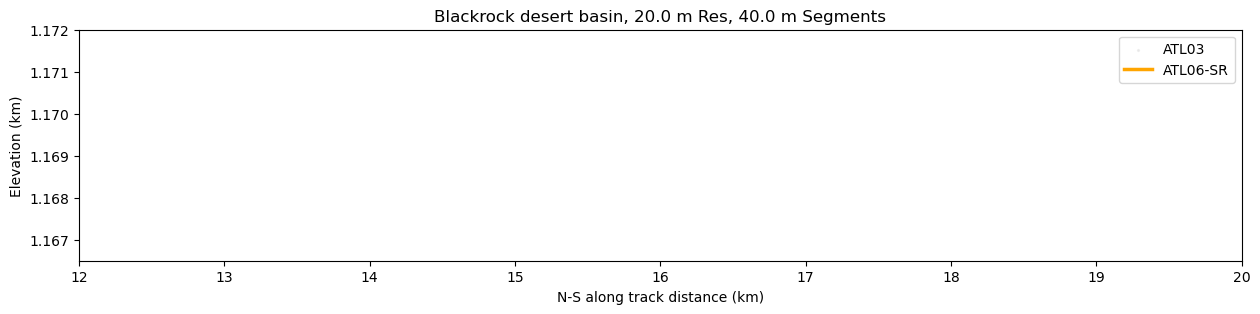

In [43]:
plt.figure(figsize=[15, 3])
plt.scatter((atl03_yapc['x_atc']-np.min(atl03_yapc['x_atc']))/1000, 
            atl03_yapc.height.values/1000, color='black', s=2, alpha=0.05, label='ATL03')
plt.plot((ss_atl06_sr['distance']-np.min(ss_atl06_sr['distance']))/1000, 
         ss_atl06_sr.h_mean/1000, color='orange', linewidth=2.5, label='ATL06-SR')
plt.title(f"Blackrock desert basin, {res} m Res, {res*2} m Segments")
plt.xlabel('N-S along track distance (km)')
plt.ylabel('Elevation (km)')
plt.ylim([1.1665, 1.172])
plt.xlim([12, 20])
plt.legend()
plt.savefig(f'{site}_res{res}_len{res*2}_cnf{cnf}.png', dpi=150)

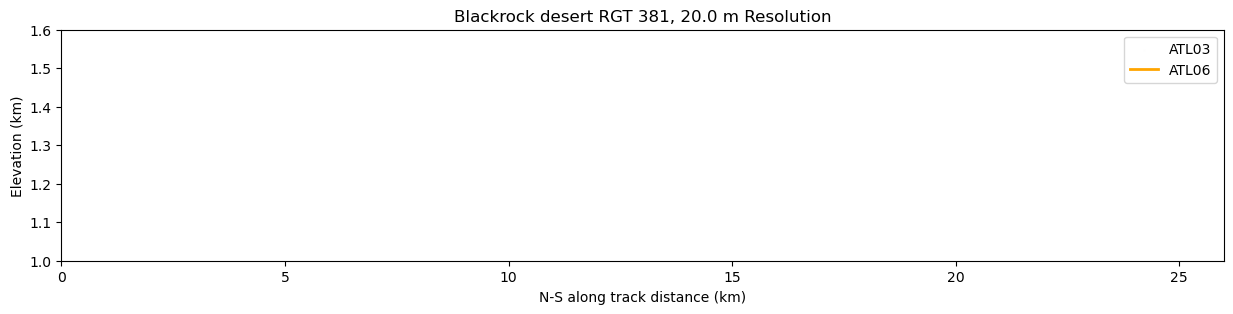

In [44]:
plt.figure(figsize=[15, 3])
plt.scatter((atl03_yapc['x_atc']-np.min(atl03_yapc['x_atc']))/1000+offset, 
            atl03_yapc.height.values/1000, color='black', s=2, alpha=0.005, label='ATL03')
plt.plot((ss_atl06_sr['distance']-np.min(ss_atl06_sr['distance']))/1000, 
         ss_atl06_sr.h_mean/1000, color='orange', linewidth=2, label='ATL06')
plt.title(f"Blac desert RGT {rgt}, {res} m Resolution")
plt.xlabel('N-S along track distance (km)')
plt.ylabel('Elevation (km)')
plt.ylim([1.0, 1.6])
plt.xlim([0, 26])
plt.legend()
plt.savefig(f'{site}_res{res}_len{res*2}_cnf{cnf}_full.png', dpi=150)

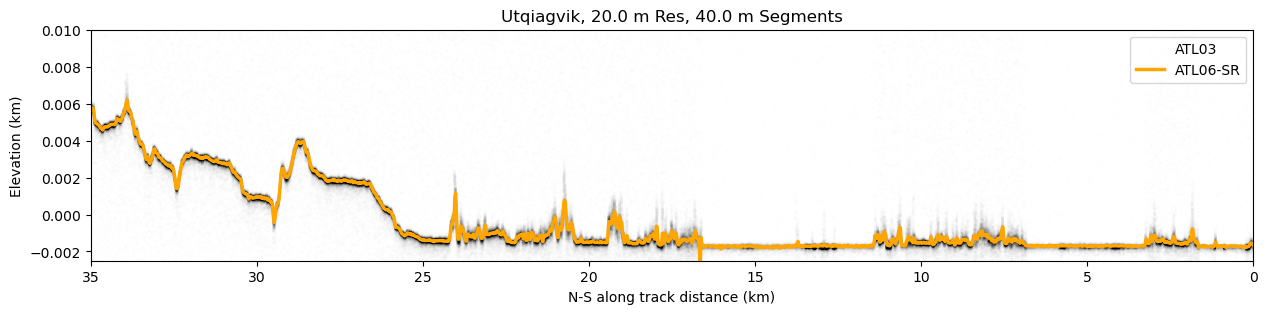

In [51]:
plt.figure(figsize=[15, 3])
plt.scatter((atl03_yapc['x_atc']-np.min(atl03_yapc['x_atc']))/1000, 
            atl03_yapc.height.values/1000, color='black', s=2, alpha=0.005, label='ATL03')
plt.plot((ss_atl06_sr['distance']-np.min(ss_atl06_sr['distance']))/1000, 
         ss_atl06_sr.h_mean/1000, color='orange', linewidth=2.5, label='ATL06-SR')
plt.title(f"Utqiagvik, {res} m Res, {res*2} m Segments")
plt.xlabel('N-S along track distance (km)')
plt.ylabel('Elevation (km)')
plt.ylim([-0.0025, 0.01])
plt.xlim([35, 0])
plt.legend()
plt.savefig(f'{site}_res{res}_len{res*2}_cnf{cnf}.png', dpi=150)

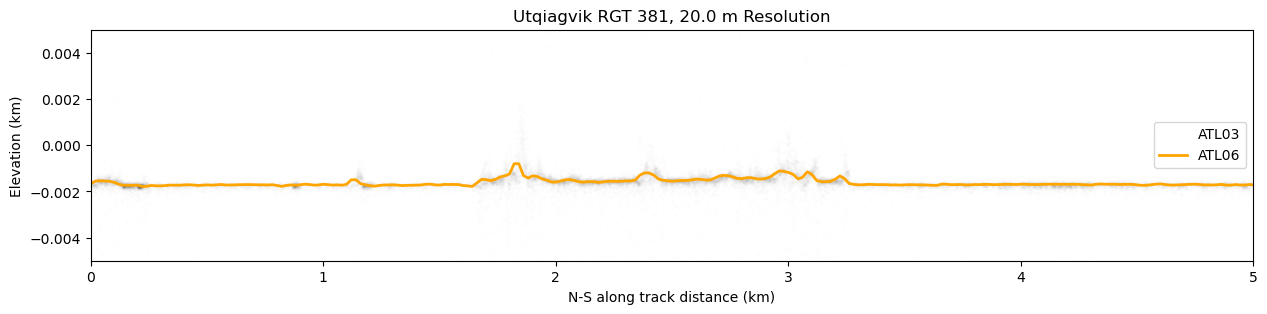

In [48]:
plt.figure(figsize=[15, 3])
plt.scatter((atl03_yapc['x_atc']-np.min(atl03_yapc['x_atc']))/1000, 
            atl03_yapc.height.values/1000, color='black', s=2, alpha=0.005, label='ATL03')
plt.plot((ss_atl06_sr['distance']-np.min(ss_atl06_sr['distance']))/1000, 
         ss_atl06_sr.h_mean/1000, color='orange', linewidth=2, label='ATL06')
plt.title(f"Utqiagvik RGT {rgt}, {res} m Resolution")
plt.xlabel('N-S along track distance (km)')
plt.ylabel('Elevation (km)')
#plt.ylim([-0.005, 0.005])
#plt.xlim([0, 5])
plt.legend()
plt.savefig(f'{site}_res{res}_len{res*2}_cnf{cnf}_full.png', dpi=150)

In [18]:
projection = 'Global'
max_plot_point = ss_atl06_sr.shape[0]
m = ipysliderule.leaflet(projection)
m.GeoData(ss_atl06_sr, column_name='h_mean', cmap='viridis', max_plot_point=max_plot_point)

display.display(m.map)

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

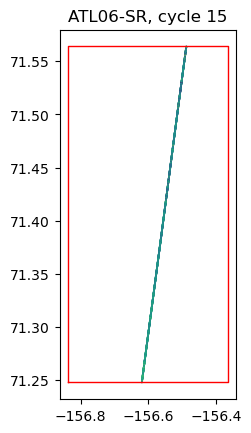

In [19]:
# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]
f, ax = plt.subplots()
ax.set_title(f"ATL06-SR, cycle {cycle}")
ax.set_aspect('equal')
ss_atl06_sr.plot(ax=ax, column='h_mean', cmap='viridis', s=0.1)
ax.plot(region_lon, region_lat, linewidth=1, color='red');

## Plot ATL06-SR vs. ATL06

In [22]:
# Save geodataframe as csv
print(f'Saving file as {filename}')
ss_atl06_sr.to_csv(filename)

Saving file as ~/surfit/data/utqiagvik_ATL06_len20_res10.csv


In [21]:
#Davey Jones' Locker

#pregion = gpd.read_file(poly_fn)
#poly = sliderule.toregion(pregion)["poly"]

# Read geojson with geopandas
#pregion = gpd.read_file(poly_fn)
#pregion.plot();

#gtDict = {10: "gt1l", 20: "gt1r", 30: "gt2l", 40: "gt2r", 50: "gt3l", 60: "gt3r"}